<font color=lightgreen>**Context**</font>: In this section, OLS Linear Regression is chosen for machine learning

<font color=lightgreen>**Question**</font>: Training a model to predict Bad debt as % in total expenses

<font color=lightgreen>**Overall**</font>: We will train 02 model and compare its MAE

## Import

In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Data preparation

Firstly, we will drop 02 columns (year and country) as well as drop "GDP in USD" column for y (prediction)

In [132]:
# YOUR CODE HERE (OPTION) 
ori_data = pd.read_csv("./data/final_data.csv")
copy_data = ori_data.copy()

In [133]:
def get_object_columns(dataframe):
    object_columns = dataframe.select_dtypes(include=['object']).columns
    return object_columns

object_columns = get_object_columns(copy_data)
#rem_cols = object_columns.difference(['city', 'state'])

print(object_columns)

copy_data.drop(object_columns, axis='columns', inplace=True)

Index(['name', 'street_address', 'city', 'state', 'urban_location_f',
       'memb_counc_teach_hosps_f', 'county', 'hospital_bed_size',
       'form_990_filed_part_grp_ret_f', 'chna_cond_w_mult_hosp_facilities_f',
       'st_impl_aca_medcd_exp_cvrg_adlts_w_incs_up_138pct_fpl_f',
       'st_law_req_hosp_rpt_comm_bnfts_f'],
      dtype='object')


In [134]:
for col in copy_data.columns[:-3]:
    median = copy_data[col].median(skipna=True)
    copy_data[col] = copy_data[col].fillna(median)
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3491 entries, 0 to 3490
Data columns (total 32 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   hospital_id                                          3491 non-null   int64  
 1   ein                                                  3491 non-null   int64  
 2   hospital_bed_count                                   3491 non-null   int64  
 3   medicare_provider_number                             3491 non-null   int64  
 4   hospital_data_id                                     3491 non-null   int64  
 5   fiscal_yr                                            3491 non-null   int64  
 6   form_990_num_fac_oper                                3491 non-null   int64  
 7   tot_func_exp                                         3491 non-null   int64  
 8   tot_revenue                                          3491 non-null  

In [135]:
cols_at_end = ['bad_debt_tot_func_exp_pct']
copy_data = copy_data[[c for c in copy_data if c not in cols_at_end] 
        + [c for c in cols_at_end if c in copy_data]]

copy_data

,hospital_id,ein,hospital_bed_count,medicare_provider_number,hospital_data_id,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_revenue,tot_comm_bnfts,...,per_capita_inc,med_hsehld_inc_qrt,med_hsehld_inc,percent_ppl_pov_qrt,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_qrt,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older_qrt,unemp_rate_16_yrs_older,bad_debt_tot_func_exp_pct
0,1,630307951,99,10007,12,2021,1,24548253,26350803,399634,...,37930,1,43544,4,17.1,3,12.5,1,3.0,13.718381
1,2,630578923,362,10011,24,2021,1,269655098,247421803,14530957,...,58424,3,57802,3,14.4,2,10.7,2,3.6,1.065159
2,3,630312913,252,10016,36,2021,5,6138054,18093135,6276227,...,59588,4,88444,1,7.0,2,8.7,1,2.1,86.370077
3,4,630459034,106,10018,39,2012,1,7281976,7873057,848514,...,45622,3,43967,3,18.6,2,14.5,2,6.8,1.481425
4,5,581973570,60,10022,43,2021,2,336272925,261011061,21995495,...,37869,2,50388,3,14.7,3,13.0,1,2.5,3.750702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3486,3487,813040663,16,670136,36264,2021,3,97887005,96294245,9631051,...,74032,4,82605,2,10.2,4,16.5,2,4.0,9.919405
3487,3488,741109643,7,670143,36267,2021,14,2379013884,2846977586,179871173,...,42177,4,74612,2,10.8,4,22.7,3,4.5,2.104334
3488,3489,831954982,63,670260,36270,2021,1,121669224,130956692,5122144,...,63283,4,90880,1,6.9,3,13.4,2,4.4,12.712880
3489,3490,750800661,46,670300,36272,2021,9,1636296370,1856448774,222654822,...,49333,4,79849,1,7.9,4,18.9,3,4.5,14.660452


In [136]:
y = copy_data["bad_debt_tot_func_exp_pct"]
y

0       13.718381
1        1.065159
2       86.370077
3        1.481425
4        3.750702
          ...    
3486     9.919405
3487     2.104334
3488    12.712880
3489    14.660452
3490     9.088709
Name: bad_debt_tot_func_exp_pct, Length: 3491, dtype: float64

In [137]:
copy_data.drop(["bad_debt_tot_func_exp_pct"], inplace=True, axis='columns')
copy_data
X = copy_data

Secondly, we will spilt it into 02 data sets (train and test)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)


In [139]:
X_train.head()

,hospital_id,ein,hospital_bed_count,medicare_provider_number,hospital_data_id,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_revenue,tot_comm_bnfts,...,per_capita_inc_qrt,per_capita_inc,med_hsehld_inc_qrt,med_hsehld_inc,percent_ppl_pov_qrt,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_qrt,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older_qrt,unemp_rate_16_yrs_older
2316,2317,900640432,1093,360020,24277,2021,2,1384761934,1396622299,178058351,...,4,56821,3,60715,2,12.1,1,8.0,3,5.4
2739,2740,240798681,25,391309,28543,2021,1,21291676,22696065,1600524,...,3,49114,3,55560,2,11.6,2,8.5,3,5.5
2767,2768,570341194,131,420020,28825,2021,1,193244262,221697740,9749898,...,3,51775,3,57991,3,15.1,3,14.2,3,4.8
2929,2930,750800661,478,450051,30444,2021,9,1636296370,1856448774,222654822,...,4,65401,4,65770,3,13.7,4,25.1,3,5.6
3155,3156,621636465,118,490027,32756,2021,6,797824334,845523767,50636852,...,0,0,1,36004,4,20.5,2,8.2,3,4.9


In [140]:
y_train.head()

2316     0.874518
2739     8.031904
2767     3.380409
2929    14.660452
3155     2.221214
Name: bad_debt_tot_func_exp_pct, dtype: float64

In [141]:
X_test.head()

,hospital_id,ein,hospital_bed_count,medicare_provider_number,hospital_data_id,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_revenue,tot_comm_bnfts,...,per_capita_inc_qrt,per_capita_inc,med_hsehld_inc_qrt,med_hsehld_inc,percent_ppl_pov_qrt,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_qrt,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older_qrt,unemp_rate_16_yrs_older
3036,3037,741356589,58,450824,31478,2011,7,31816283,84420606,40555947,...,4,48649,4,53303,3,18.1,4,22.4,2,6.6
875,876,370663568,25,141336,9134,2021,1,42949575,52229600,1069344,...,3,51433,3,63903,2,11.0,1,6.4,3,4.9
570,571,822567308,120,100211,5864,2021,1,75031465,75746420,11313648,...,2,45461,2,52332,2,11.4,4,15.7,2,4.4
299,300,941044474,85,50442,3075,2012,2,194919985,192968149,9727001,...,2,34345,4,50431,3,18.5,3,19.5,4,15.2
156,157,463851119,25,41318,1509,2021,1,15588916,17548039,327696,...,1,34433,1,43577,3,15.8,2,10.1,2,4.2


In [142]:
y_test.head()

3036    13.390317
875      0.000000
570      9.483966
299      1.634681
156      3.211609
Name: bad_debt_tot_func_exp_pct, dtype: float64

## Feature engineering

We will find some good features for training

### Model 1: using some tools

Firstly, we will eleminate some redundant by repeated-KFold

In [ ]:
# YOUR CODE HERE (OPTION)
avg_mutual = 0
for i in range(5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

    grid = dict()
    grid['sel__k'] = [i for i in range(X_train.shape[1]-20, X_train.shape[1]+1)]

    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

    results = search.fit(X_train, y_train)

    #print('Best MAE: %.3f' % results.best_score_)
    best_config = results.best_params_
    best_sel_k = best_config['sel__k']
    avg_mutual += int(best_sel_k)
print('Best Config for mutual: %s' % int(avg_mutual / 5))
#############################################################

avg_col = 0
for i in range(5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    model = LinearRegression()
    fs = SelectKBest(score_func=f_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

    grid = dict()
    grid['sel__k'] = [i for i in range(X_train.shape[1]-20, X_train.shape[1]+1)]

    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

    results = search.fit(X_train, y_train)

    #print('Best MAE: %.3f' % results.best_score_)
    best_config = results.best_params_
    best_sel_k = best_config['sel__k']
    avg_col += int(best_sel_k)
print('Best Config for correlation: %s' % int(avg_col / 5))

In [ ]:
# model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# model_gb.fit(X_train, y_train)
# y_pred_gb = model_gb.predict(X_test)


# mse_gb = mean_squared_error(y_test, y_pred_gb)
# feature_importances = model_gb.feature_importances_

# for i, importance in enumerate(feature_importances):
#     print(f"Feature {i}: {importance}")
# print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')

Secondly, we will find 03 features

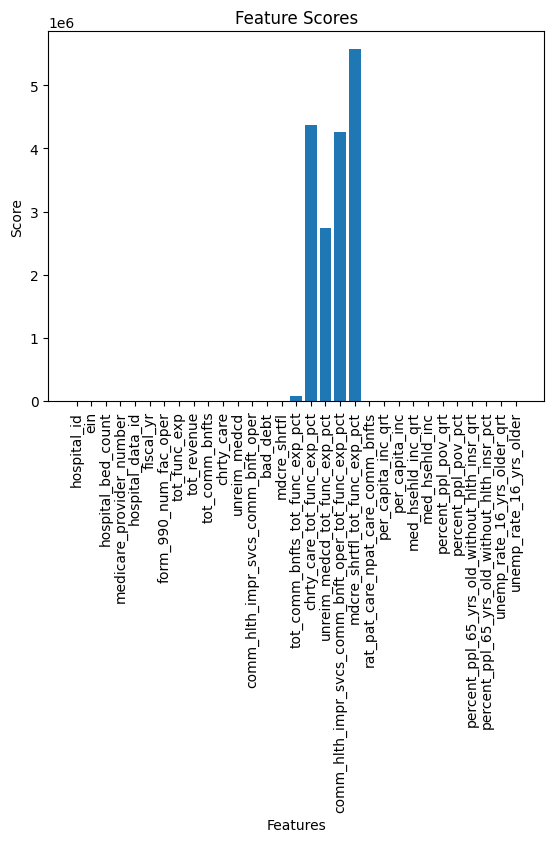

In [144]:
def select_features(X_train, y_train, X_test):

 fs = SelectKBest(score_func=f_regression, k=int(avg_col / 5))

 fs.fit(X_train, y_train)

 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X_train.columns

plt.bar(range(len(fs.scores_)), fs.scores_)

plt.xticks(range(len(fs.scores_)), feature_names, rotation='vertical')

plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Scores')

plt.show()

So, mdcre_shrtfl_tot_func_exp_pct is the first one.

In [148]:
mae_1 = {}
for i in X_train.columns:
    tree = DecisionTreeRegressor(random_state=23)
    tree.fit(X_train[[i]], y_train)
    
    # prediction
    y_pred = tree.predict(X_test[[i]])
    
    # compute the regression evaluation metric, e.g., Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    mae_1[i] = mae
best_skill = min(mae_1, key=mae_1.get)
print(f"Best Skill: {best_skill}")
print(f"MAE for Best Skill: {mae_1[best_skill]}")


Best Skill: bad_debt
MAE for Best Skill: 4.147424729134608


bad_debt is the next feature.

c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


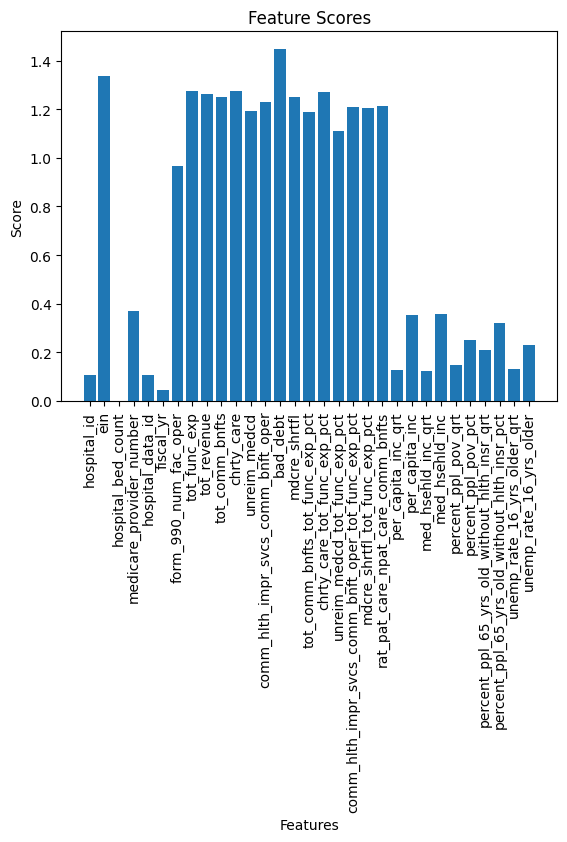

In [149]:
def select_features(X_train, y_train, X_test):

 fs = SelectKBest(score_func=mutual_info_regression, k=int(avg_mutual / 5))

 fs.fit(X_train, y_train)

 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X_train.columns

plt.bar(range(len(fs.scores_)), fs.scores_)

plt.xticks(range(len(fs.scores_)), feature_names, rotation='vertical')

plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Scores')

plt.show()

Finally, ein is the last one.

### Model 2: We will choose some features based on the correlation in file 3.0-eda.ipynb

Based on heatmap, we will choose Agriculture value added(in USD) and Net income from Abroad

## Training model

In [150]:
# YOUR CODE HERE (OPTION) 
X_final_1_train = X_train[['mdcre_shrtfl_tot_func_exp_pct', 'ein', 'bad_debt']]
X_final_1_test = X_test[['mdcre_shrtfl_tot_func_exp_pct', 'ein', 'bad_debt']]

X_2_train = X_train[['comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct', 'mdcre_shrtfl_tot_func_exp_pct', 'chrty_care_tot_func_exp_pct']]
X_2_test = X_test[['comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct', 'mdcre_shrtfl_tot_func_exp_pct', 'chrty_care_tot_func_exp_pct']]
X_final_2_train = pd.concat([X_2_train, X_train[['tot_comm_bnfts_tot_func_exp_pct']]*(-1), X_train[['unreim_medcd_tot_func_exp_pct']]*(-1)], axis=1)
X_final_2_test = pd.concat([X_2_train, X_train[['tot_comm_bnfts_tot_func_exp_pct']]*(-1), X_train[['unreim_medcd_tot_func_exp_pct']]*(-1)], axis=1)

In [151]:
X_final_1_train.head()

,mdcre_shrtfl_tot_func_exp_pct,ein,bad_debt
2316,-0.673804,900640432,12110000
2739,-3.766514,240798681,1710127
2767,-5.405649,570341194,6532446
2929,-1.924540,750800661,239888450
3155,1.298961,621636465,17721390


In [152]:
X_final_2_train.head()

,comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct,mdcre_shrtfl_tot_func_exp_pct,chrty_care_tot_func_exp_pct,tot_comm_bnfts_tot_func_exp_pct,unreim_medcd_tot_func_exp_pct
2316,0.928849,-0.673804,1.012004,-12.858409,-4.904791
2739,0.042434,-3.766514,0.245396,-7.517135,-7.229304
2767,0.968346,-5.405649,2.303859,-5.045375,-1.464412
2929,0.115922,-1.924540,6.911231,-13.607243,-2.586084
3155,0.407203,1.298961,0.927230,-6.346867,-2.967212


In [153]:
y_train

2316     0.874518
2739     8.031904
2767     3.380409
2929    14.660452
3155     2.221214
          ...    
1981     8.374700
1649     0.000000
2758     1.452316
1660     3.073373
1786     5.047820
Name: bad_debt_tot_func_exp_pct, Length: 2792, dtype: float64

Model 1

In [154]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_ = LinearRegression()
model_.fit(X_final_1_train, y_train)

score_1 = cross_val_score(model_, X_final_1_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_1)))

Mean of this model:  6.389348779283852


Model 2

In [155]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_ = LinearRegression()
model_.fit(X_final_2_train, y_train)

score_1 = cross_val_score(model_, X_final_2_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_1)))

Mean of this model:  15.637755338365002


So we will choose model 1

## Evaluation

Re-training

In [156]:
# YOUR CODE HERE (OPTION) 
model_1 = LinearRegression()
model_1.fit(X_final_1_train, y_train)

print("coef: ", model_1.coef_)
print("intercept: ", model_1.intercept_)

coef:  [ 9.99972264e-01  3.83530243e-09 -2.34604466e-09]
intercept:  5.514653346189846


In [157]:
score_1 = cross_val_score(model_1, X_final_1_test, y_test, scoring = "neg_mean_absolute_error")
print("MAE of new model: ", mean(absolute(score_1)))

MAE of new model:  7.339222448345934


## Prediction

Thus,
$$\text{GDP (in USD)} = (53.60473212) * Agriculture value added(in USD) + (37.96430544) * Net income from Abroad \\
+ 25955448733.0058$$

==> Note that the coef and intercept may change due to the restart, this was my result.

In [22]:
# YOUR CODE HERE (OPTION) 

## Results analysis

Here is the MAE of the whole train set, which means we include all feature to the model. It can be seen as the avg MAE.

In [158]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_ = LinearRegression()
model_.fit(X_train, y_train)

score_1 = cross_val_score(model_, X_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_1)))

Mean of this model:  16.80059900139253


In [159]:
# YOUR CODE HERE (OPTION) 
y

0       13.718381
1        1.065159
2       86.370077
3        1.481425
4        3.750702
          ...    
3486     9.919405
3487     2.104334
3488    12.712880
3489    14.660452
3490     9.088709
Name: bad_debt_tot_func_exp_pct, Length: 3491, dtype: float64

Here, as we can see, MAE of this model is less than MAE of whole feature.

## Conclusion

**Your conclusion**

- We can combine various feature for training our model to predict a specific feature.
- By sorting feature's correlation, we can choose some weighty feature, thus, our precise is higher.